# **Phân tích cảm xúc văn bản (Sentiment Analysis) bằng LDA**

### **Import Modules**

In [1]:
import pandas as pd
import re
import numpy as np
import math
from collections import defaultdict
import os
import matplotlib.pyplot as plt

### **Load Dataset**



In [2]:
df = pd.read_csv('IMDB Dataset.csv')
df = df.tail(1000)
data = list(zip(df['review'].values, df['sentiment'].values))

## **Tiền xử lý dữ liệu**

### Text Cleaning

In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

### Tokenizing

In [4]:
def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens


### Deleting stop words
Stop words là các từ không mang nhiều ý nghĩa trong text.


In [6]:

stop_words = set()
with open('stop_words.txt', 'r', encoding='utf-8') as f:
    for line in f:
        words = line.split()
        stop_words.update(words)


def delete_stop_words(tokens):
    return [token for token in tokens if token not in stop_words]

### Clean data

In [7]:
def clean_data(data):
    cleaned_data = []
    for text, label in data:
        cleaned_text = clean_text(text)
        tokens = delete_stop_words(tokenize(cleaned_text))
        cleaned_data.append((' '.join(tokens), label))
    return cleaned_data


data = clean_data(data)

## **Biểu diễn văn bản với TF-IDF**

**TF-IDF** (Term Frequency - Inverse Document Frequency) là phương pháp để đánh giá mức độ quan trọng của một từ **t** trong một văn bản **d** và tập văn bản **D**, được tính như sau:

${TF(t, d)} = \frac{số~lần~t~xuất~hiện~trong~d}{tổng~số~từ~của~d}$

${DF(t, D)} = số~văn~bản~d~có~t~trong~D$

${IDF(t, D)} = log\frac{N_D}{1 + DF}$

${TF - IDF(t,d)} = TF * IDF$


### Tính TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


def tf_idf(data):
    texts, labels = zip(*data)
    vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=5000,
        min_df=2,
        max_df=0.95,
        lowercase=True,
    )
    X = vectorizer.fit_transform(texts)
    vocabulary = vectorizer.get_feature_names_out()
    tfidf_dict = {}

    for doc_id, doc_vector in enumerate(X):
        # Khởi tạo dictionary cho document này
        doc_key = f'doc_{doc_id}'
        tfidf_dict[doc_key] = {}

        non_zero_indices = doc_vector.nonzero()[1]

        for idx in non_zero_indices:
            word = vocabulary[idx]
            tfidf_value = doc_vector[0, idx]
            if tfidf_value > 0:  # thêm điều kiện này để chắc chắn
                tfidf_dict[doc_key][word] = tfidf_value

    # Tạo mapping doc_id to label
    doc_to_label = {f'doc_{i}': label for i, label in enumerate(labels)}

    return tfidf_dict, vectorizer, doc_to_label, vocabulary


tf_idf, vectorizer, doc_to_label, vocabulary = tf_idf(data)

### Visualize

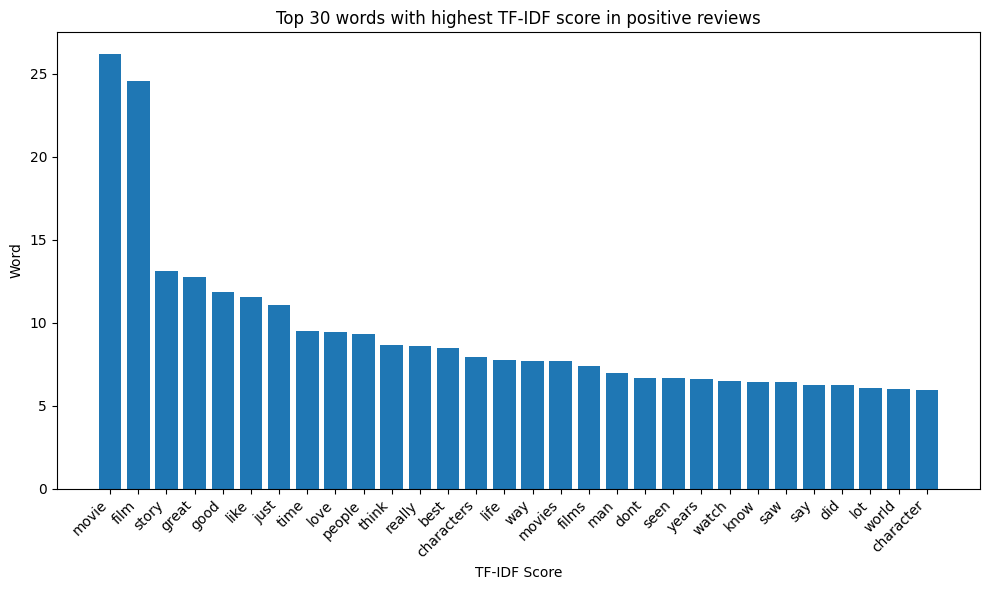

In [9]:
positive_scores = defaultdict(float)
for doc_id, label in doc_to_label.items():
    if label == 'positive':
        for word, score in tf_idf[doc_id].items():
            positive_scores[word] += score

top_30_positive_words = sorted(positive_scores, key=positive_scores.get, reverse=True)[:30]
top_30_positive_scores = [positive_scores[word] for word in top_30_positive_words]

plt.figure(figsize=(10, 6))
plt.bar(top_30_positive_words, top_30_positive_scores)
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 30 words with highest TF-IDF score in positive reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


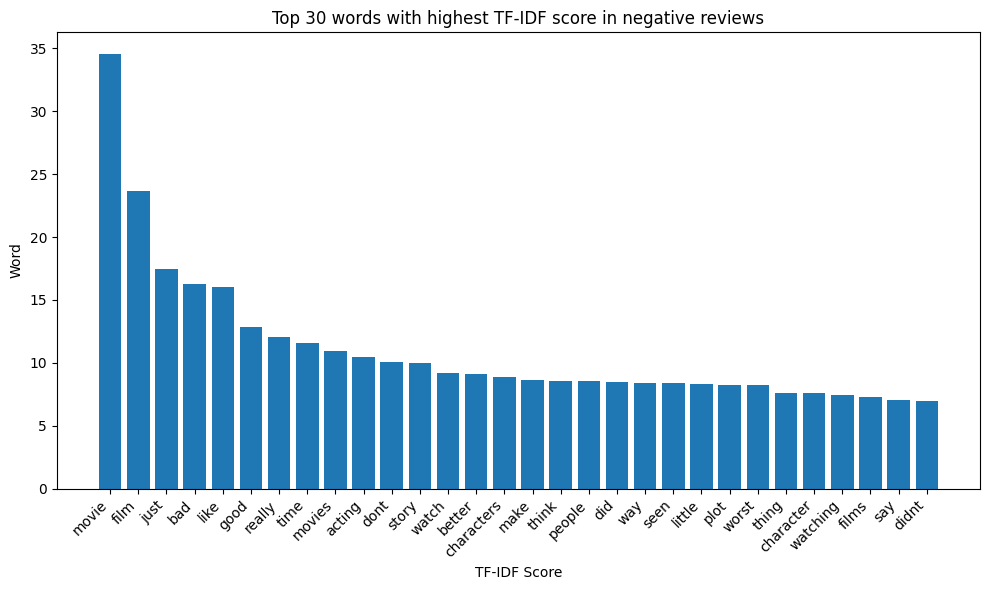

In [10]:
negative_scores = defaultdict(float)
for doc_id, label in doc_to_label.items():
    if label == 'negative':
        for word, score in tf_idf[doc_id].items():
            negative_scores[word] += score

top_30_negative_words = sorted(negative_scores, key=negative_scores.get, reverse=True)[:30]
top_30_negative_scores = [negative_scores[word] for word in top_30_negative_words]

plt.figure(figsize=(10, 6))
plt.bar(top_30_negative_words, top_30_negative_scores)
plt.xlabel('TF-IDF Score')
plt.ylabel('Word')
plt.title('Top 30 words with highest TF-IDF score in negative reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Chuyển dữ liệu thành dạng ma trận

In [11]:
import numpy as np


def prepare_data(tf_idf, vocabulary, doc_to_label):
    X = []
    y = []
    for doc_id, doc_vector in tf_idf.items():
        X.append([doc_vector.get(word, 0) for word in vocabulary])
        y.append(doc_to_label[doc_id])
    return np.array(X), np.array(y)


X, y = prepare_data(tf_idf, vocabulary, doc_to_label)

### Normalize dữ liệu

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

## **Áp dụng Linear Discriminant Analysis để giảm chiều dữ liệu**

### LDA cơ bản

In [12]:
class LDA:

    def __init__(self, n_components):
        self.n_components = n_components
        self.linear_discriminants = None

    def fit(self, X, y):
        n_features = X.shape[1]
        class_labels = np.unique(y)

        # Within class scatter matrix:
        # SW = sum((X_c - mean_X_c)^2 )

        # Between class scatter:
        # SB = sum( n_c * (mean_X_c - mean_overall)^2 )

        mean_overall = np.mean(X, axis=0)
        SW = np.zeros((n_features, n_features))
        SB = np.zeros((n_features, n_features))
        for c in class_labels:
            X_c = X[y == c]
            mean_c = np.mean(X_c, axis=0)
            SW += (X_c - mean_c).T.dot((X_c - mean_c))
            n_c = X_c.shape[0]
            mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
            SB += n_c * (mean_diff).dot(mean_diff.T)
        # Xu ly ma tran don (Sw)
        try:
            Sw_inv = np.linalg.inv(SW)
            eig_vals, eig_vecs = np.linalg.eig(Sw_inv.dot(SB))
        except np.linalg.LinAlgError:
            # Nếu Sw không khả nghịch, thêm một lượng nhỏ vào đường chéo
            print("Warning: Adding small regularization term...")
            Sw_reg = SW + np.eye(SW.shape[0]) * 1e-4
            Sw_inv = np.linalg.inv(Sw_reg)
            eig_vals, eig_vecs = np.linalg.eig(Sw_inv.dot(SB))

        idx = eig_vals.argsort()[::-1]
        eig_vals = eig_vals[idx]
        eig_vecs = eig_vecs[:, idx]
        self.linear_discriminants = eig_vecs[0:self.n_components]

    def transform(self, X):
        return np.dot(X, self.linear_discriminants.T)


lda = LDA(n_components=1)
lda.fit(X, y)
X_lda = lda.transform(X)

C:\Users\ngona\AppData\Local\Temp\ipykernel_43696\1341987081.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  X_lda_visualize = X_lda_visualize.astype(np.float64)
c:\Users\ngona\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\ngona\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_histograms_impl.py:858: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\ngona\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_histograms_impl.py:901: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
c:\Users\ngona\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:7004: ComplexWarning: Casting complex values to real dis

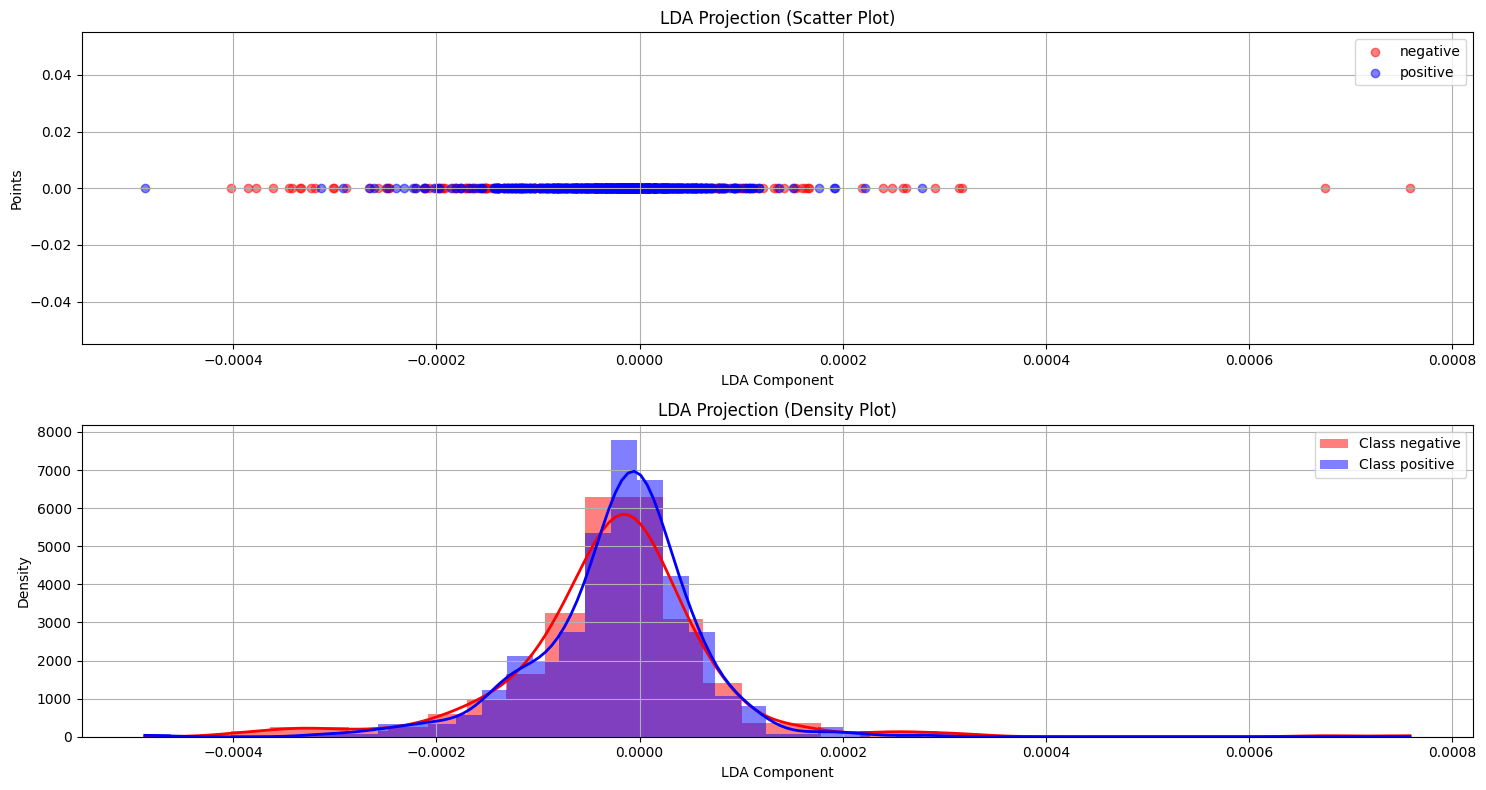

In [13]:
X_lda_visualize = X_lda.reshape(-1)
plt.figure(figsize=(15, 8))

unique_labels = np.unique(y)
colors = ['r', 'b']

X_lda_visualize = X_lda_visualize.astype(np.float64)

plt.subplot(2, 1, 1)
for label, color in zip(unique_labels, colors):
    plt.scatter(X_lda_visualize[y == label], np.zeros(len(X_lda_visualize[y == label])), c=color,
                label=label,
                alpha=0.5)
plt.title('LDA Projection (Scatter Plot)')
plt.xlabel('LDA Component')
plt.ylabel('Points')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in zip(unique_labels, colors):
    mask = y == label
    # Histogram
    plt.hist(X_lda[mask], bins=30, color=color, alpha=0.5,
             density=True, label=f'Class {label}')

    # Kernel Density Estimation
    from scipy.stats import gaussian_kde

    density = gaussian_kde(X_lda_visualize[mask].ravel())
    xs = np.linspace(X_lda_visualize.min(), X_lda_visualize.max(), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2)

plt.title('LDA Projection (Density Plot)')
plt.xlabel('LDA Component')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




### LDA với thư viện sklearn

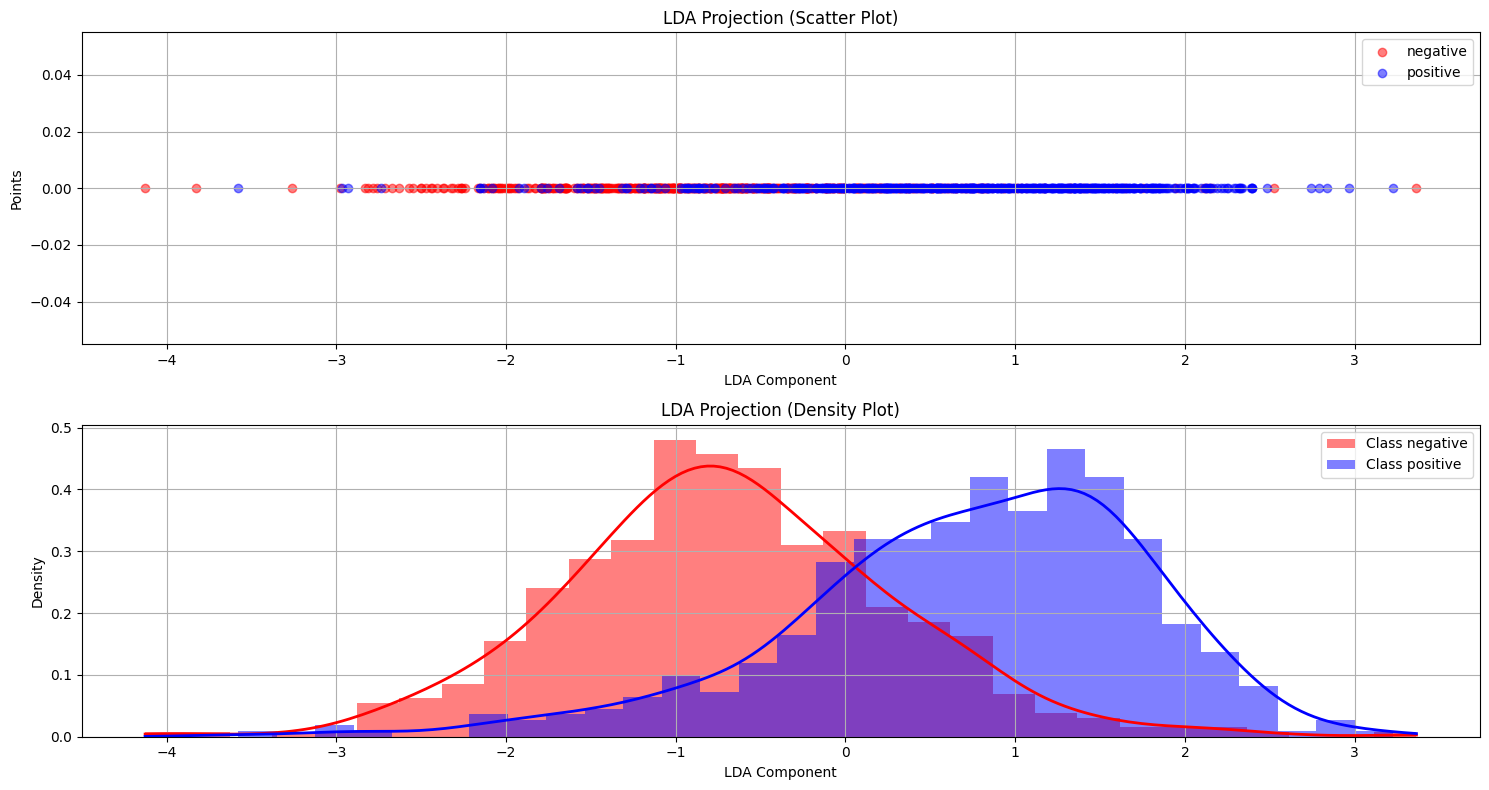

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda_sklearn = lda.fit_transform(X, y)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
unique_labels = np.unique(y)
colors = ['r', 'b']

for label, color in zip(unique_labels, colors):
    plt.scatter(X_lda_sklearn[y == label], np.zeros(len(X_lda_sklearn[y == label])), c=color, label=label, alpha=0.5)

plt.title('LDA Projection (Scatter Plot)')
plt.xlabel('LDA Component')
plt.ylabel('Points')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in zip(unique_labels, colors):
    mask = y == label
    # Histogram
    plt.hist(X_lda_sklearn[mask], bins=30, color=color, alpha=0.5,
             density=True, label=f'Class {label}')

    # Kernel Density Estimation
    from scipy.stats import gaussian_kde

    density = gaussian_kde(X_lda_sklearn[mask].ravel())
    xs = np.linspace(X_lda_sklearn.min(), X_lda_sklearn.max(), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2)

plt.title('LDA Projection (Density Plot)')
plt.xlabel('LDA Component')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Áp dụng 1 mô hình phân loại có sẵn để dự đoán

### Chia dữ liệu

In [15]:
from sklearn.model_selection import train_test_split

# S dụng LDA tự code
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=0.2, random_state=42)

# Sử dụng LDA của sklearn
X_train_lda_sklearn, X_test_lda_sklearn, y_train_lda_sklearn, y_test_lda_sklearn = train_test_split(X_lda_sklearn, y,
                                                                                                    test_size=0.2,
                                                                                                    random_state=42)

### Áp dụng mô hình support vector machine

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_lda = X_train_lda.astype(np.float64)
X_test_lda = X_test_lda.astype(np.float64)

# Sử dụng LDA tự code
svm = SVC()
svm.fit(X_train_lda, y_train_lda)
y_pred_lda = svm.predict(X_test_lda)
print(f'Accuracy with LDA self-implemented: {accuracy_score(y_test_lda, y_pred_lda)}')

# Sử dụng LDA của sklearn
svm = SVC()
svm.fit(X_train_lda_sklearn, y_train_lda_sklearn)
y_pred_lda_sklearn = svm.predict(X_test_lda_sklearn)
print(f'Accuracy with LDA from sklearn: {accuracy_score(y_test_lda_sklearn, y_pred_lda_sklearn)}')

Accuracy with LDA self-implemented: 0.465
Accuracy with LDA from sklearn: 0.77


C:\Users\ngona\AppData\Local\Temp\ipykernel_43696\3348083128.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  X_train_lda = X_train_lda.astype(np.float64)
C:\Users\ngona\AppData\Local\Temp\ipykernel_43696\3348083128.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  X_test_lda = X_test_lda.astype(np.float64)


## Đánh giá mô hình

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns

In [18]:

print('Precision with LDA self-implemented:', precision_score(y_test_lda, y_pred_lda, average='weighted').round(4))
print('Recall with LDA self-implemented:', recall_score(y_test_lda, y_pred_lda, average='weighted').round(4))
print('F1 score with LDA self-implemented:', f1_score(y_test_lda, y_pred_lda, average='weighted').round(4))

Precision with LDA self-implemented: 0.4645
Recall with LDA self-implemented: 0.465
F1 score with LDA self-implemented: 0.4646


Confusion matrix with LDA self-implemented:


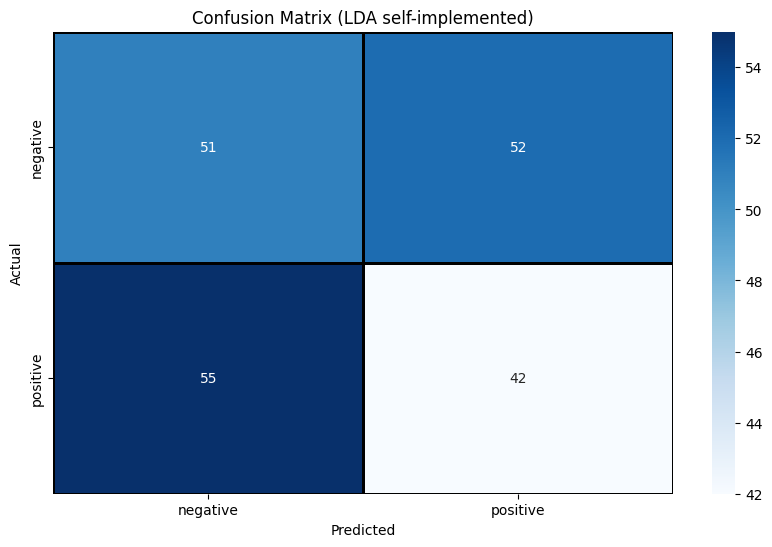

In [19]:
print('Confusion matrix with LDA self-implemented:')
cm_self = confusion_matrix(y_test_lda, y_pred_lda)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_self, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y),
            linewidths=1, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LDA self-implemented)')
plt.show()

In [20]:
print('Precision with LDA from sklearn:',
      precision_score(y_test_lda_sklearn, y_pred_lda_sklearn, average='weighted').round(4))
print('Recall with LDA from sklearn:',
      recall_score(y_test_lda_sklearn, y_pred_lda_sklearn, average='weighted').round(4))
print('F1 score with LDA from sklearn:', f1_score(y_test_lda_sklearn, y_pred_lda_sklearn, average='weighted').round(4))

Precision with LDA from sklearn: 0.77
Recall with LDA from sklearn: 0.77
F1 score with LDA from sklearn: 0.7699


Confusion matrix with LDA from sklearn:


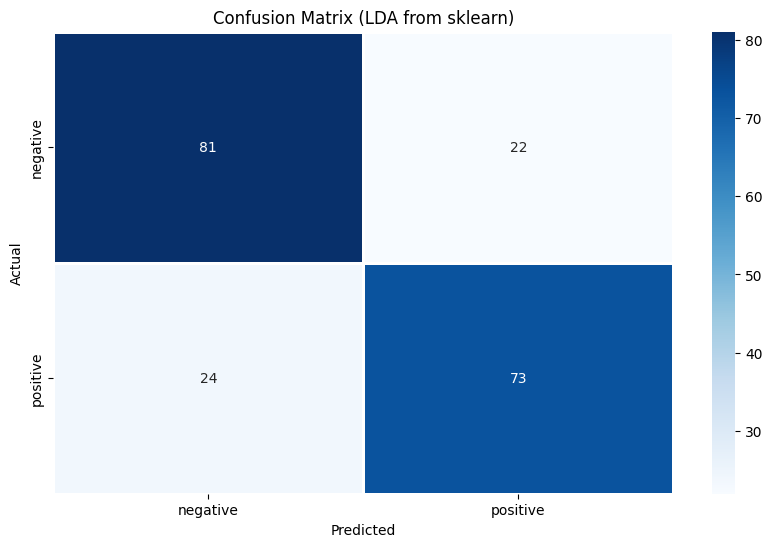

In [21]:
print('Confusion matrix with LDA from sklearn:')
cm_sklearn = confusion_matrix(y_test_lda_sklearn, y_pred_lda_sklearn)
plt.figure(figsize=(10, 6))
sns.heatmap(cm_sklearn, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y),
            linewidths=1, linecolor='white')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (LDA from sklearn)')
plt.show()

## So sánh với NMF và PCA

### NMF

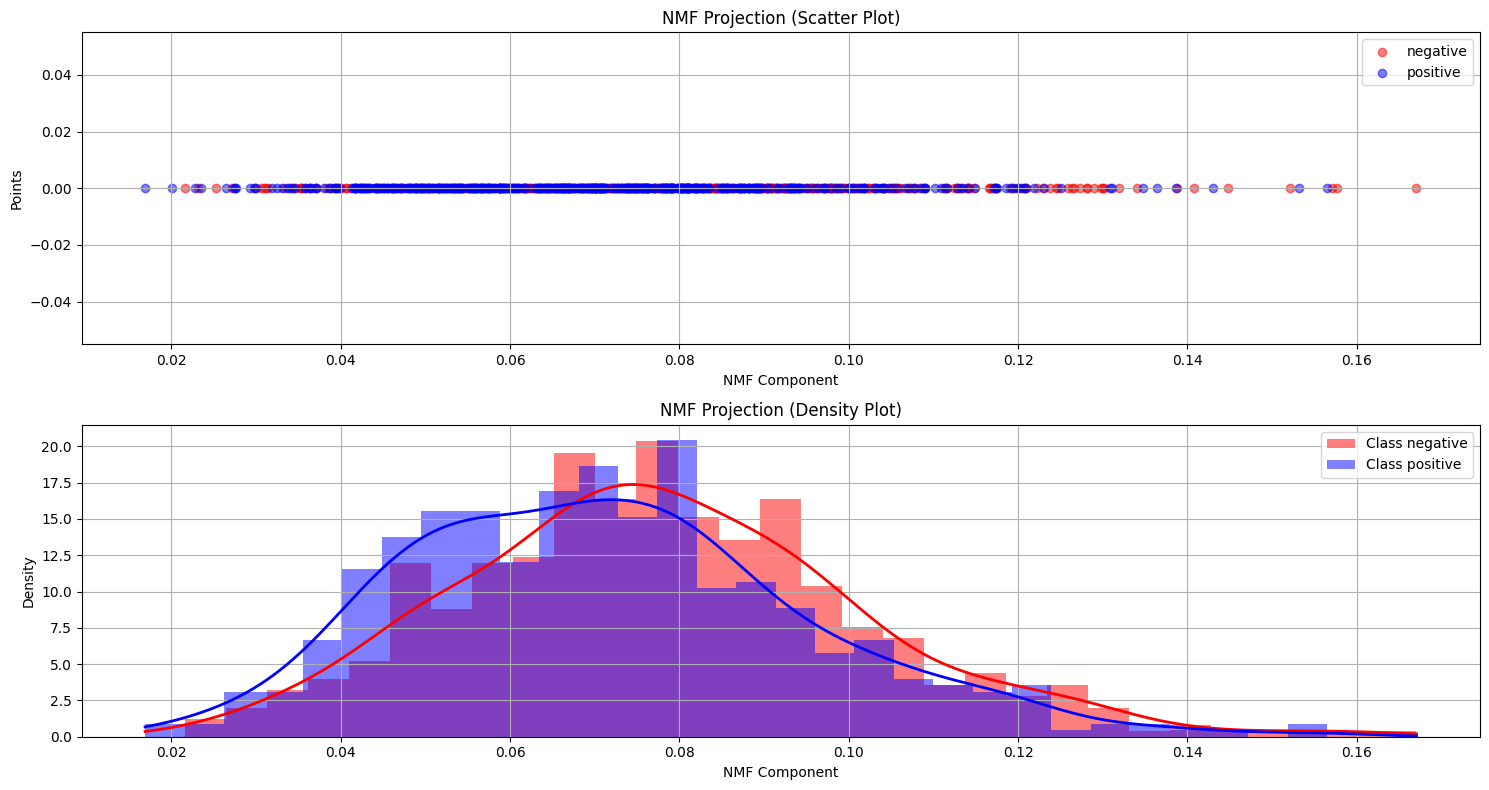

In [22]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=1)
X_nmf = nmf.fit_transform(X)

# Plot
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
unique_labels = np.unique(y)

for label, color in zip(unique_labels, colors):
    plt.scatter(X_nmf[y == label], np.zeros(len(X_nmf[y == label])), c=color, label=label, alpha=0.5)

plt.title('NMF Projection (Scatter Plot)')
plt.xlabel('NMF Component')
plt.ylabel('Points')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in zip(unique_labels, colors):
    mask = y == label
    # Histogram
    plt.hist(X_nmf[mask], bins=30, color=color, alpha=0.5,
             density=True, label=f'Class {label}')

    # Kernel Density Estimation
    density = gaussian_kde(X_nmf[mask].ravel())
    xs = np.linspace(X_nmf.min(), X_nmf.max(), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2)

plt.title('NMF Projection (Density Plot)')
plt.xlabel('NMF Component')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
svm = SVC()
X_train_nmf, X_test_nmf, y_train_nmf, y_test_nmf = train_test_split(X_nmf, y, test_size=0.2, random_state=42)
svm.fit(X_train_nmf, y_train_nmf)
y_pred_nmf = svm.predict(X_test_nmf)
print(f'Accuracy with NMF: {accuracy_score(y_test_nmf, y_pred_nmf)}')

Accuracy with NMF: 0.505


### PCA

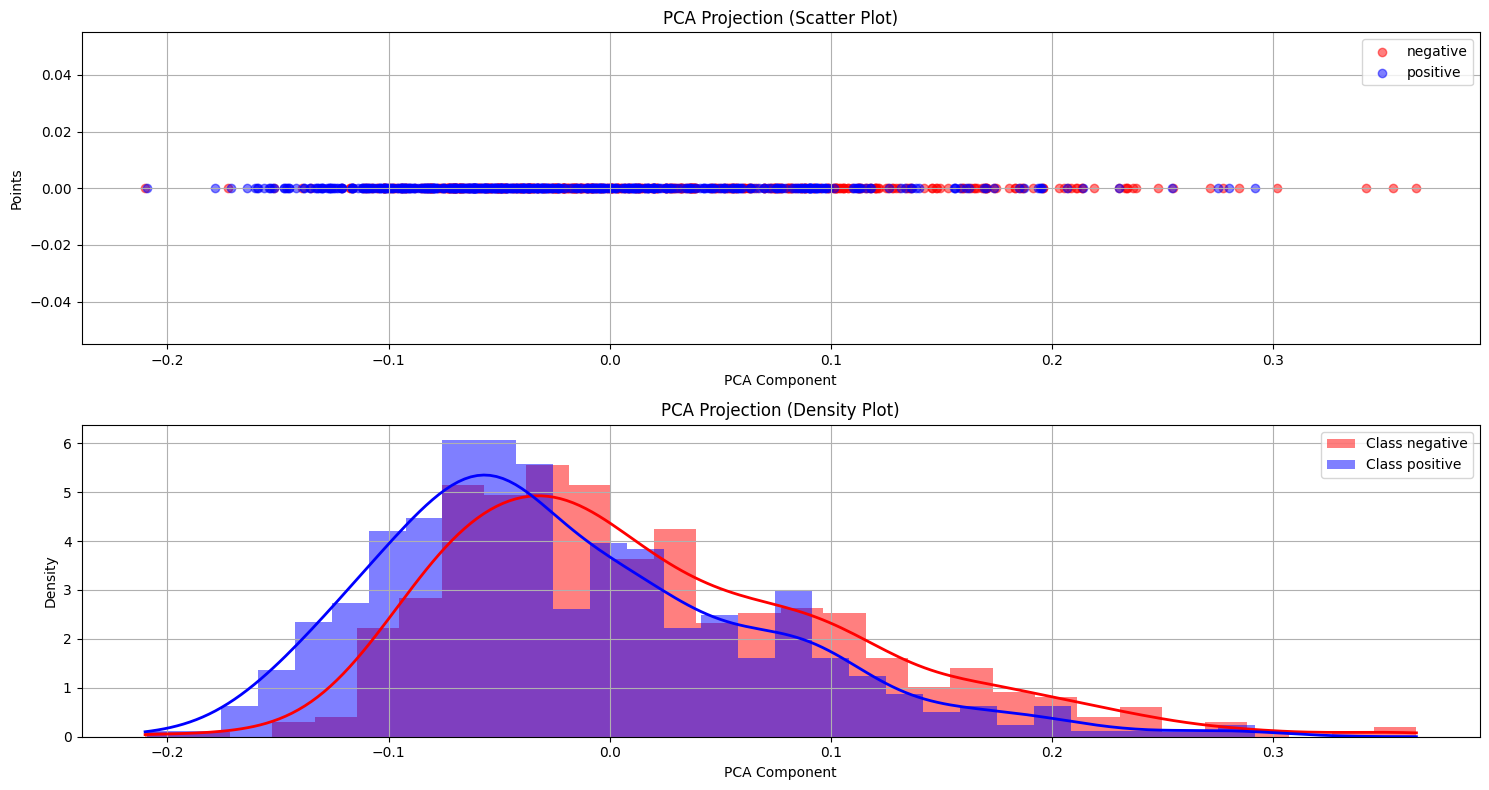

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
unique_labels = np.unique(y)

for label, color in zip(unique_labels, colors):
    plt.scatter(X_pca[y == label], np.zeros(len(X_pca[y == label])), c=color, label=label, alpha=0.5)

plt.title('PCA Projection (Scatter Plot)')
plt.xlabel('PCA Component')
plt.ylabel('Points')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in zip(unique_labels, colors):
    mask = y == label
    # Histogram
    plt.hist(X_pca[mask], bins=30, color=color, alpha=0.5,
             density=True, label=f'Class {label}')

    # Kernel Density Estimation
    density = gaussian_kde(X_pca[mask].ravel())
    xs = np.linspace(X_pca.min(), X_pca.max(), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2)

plt.title('PCA Projection (Density Plot)')
plt.xlabel('PCA Component')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
svm = SVC()
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)
svm.fit(X_train_pca, y_train_pca)
y_pred_pca = svm.predict(X_test_pca)
print(f'Accuracy with PCA: {accuracy_score(y_test_pca, y_pred_pca)}')

Accuracy with PCA: 0.54


### SVD

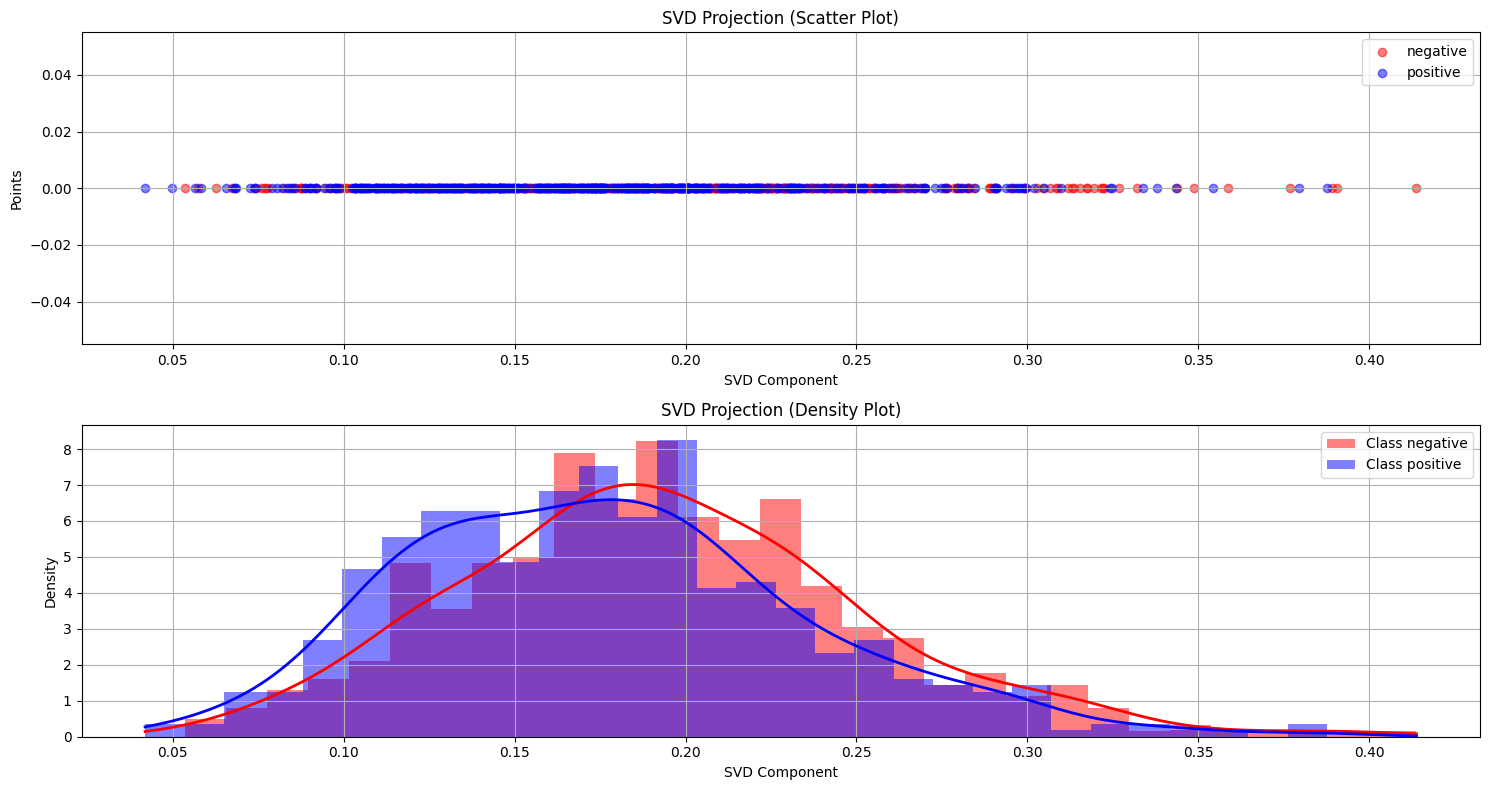

In [26]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1)
X_svd = svd.fit_transform(X)

# Plot
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
unique_labels = np.unique(y)

for label, color in zip(unique_labels, colors):
    plt.scatter(X_svd[y == label], np.zeros(len(X_svd[y == label])), c=color, label=label, alpha=0.5)

plt.title('SVD Projection (Scatter Plot)')
plt.xlabel('SVD Component')
plt.ylabel('Points')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
for label, color in zip(unique_labels, colors):
    mask = y == label
    # Histogram
    plt.hist(X_svd[mask], bins=30, color=color, alpha=0.5,
             density=True, label=f'Class {label}')

    # Kernel Density Estimation
    density = gaussian_kde(X_svd[mask].ravel())
    xs = np.linspace(X_svd.min(), X_svd.max(), 200)
    plt.plot(xs, density(xs), color=color, linewidth=2)

plt.title('SVD Projection (Density Plot)')
plt.xlabel('SVD Component')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
svm = SVC()
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.2, random_state=42)
svm.fit(X_train_svd, y_train_svd)
y_pred_svd = svm.predict(X_test_svd)
print(f'Accuracy with SVD: {accuracy_score(y_test_svd, y_pred_svd)}')

Accuracy with SVD: 0.505
